In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.figure_factory as ff
from PIL import Image

df = pd.read_csv("data_toxins__structures_merge_drop.csv")

print(df.shape)

(3678, 57)


In [57]:
print(df.columns)

Index(['id', 'common_name', 'description', 'cas', 'chemical_formula',
       'appearance', 'route_of_exposure', 'mechanism_of_toxicity',
       'metabolism', 'toxicity', 'lethaldose', 'carcinogenicity', 'use_source',
       'health_effects', 'symptoms', 'export', 'moldb_smiles', 'moldb_formula',
       'moldb_inchi', 'moldb_inchikey', 'moldb_average_mass', 'origin',
       'state', 'carcinogenicity_grouped', 'carcinogenicity_label',
       'types_all', 'locations_all', 'DATABASE_ID', 'DATABASE_NAME', 'SMILES',
       'INCHI_IDENTIFIER', 'INCHI_KEY', 'FORMULA', 'JCHEM_ACCEPTOR_COUNT',
       'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY',
       'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER',
       'JCHEM_IUPAC', 'JCHEM_LOGP', 'JCHEM_MDDR_LIKE_RULE',
       'JCHEM_NUMBER_OF_RINGS', 'JCHEM_PHYSIOLOGICAL_CHARGE',
       'JCHEM_POLAR_SURFACE_AREA', 'JCHEM_REFRACTIVITY',
       'JCHEM_ROTATABLE_BOND_COUNT', 'JCHEM_RULE_OF_FIVE',
       'JCHEM_TRADITIONAL_IUPAC', 

Basandomi sul gruppo IARC di riferimento, per una migliore interpretazione dei dati aggrego e trasformo le precedenti classi di cancerogenicità:

0 = non classificato o non cancerogeno (Gruppo 3);

1 = cancerogeno certo (Gruppo 1) o possibile/probabile cancerogeno (Gruppi 2A/2B);

In [58]:
def convert_carcinogenicity(text):
    text = str(text).lower()

    if "group 1" in text or "1, carcinogenic to humans" in text:
        return 1
    elif "group 2a" in text or "2a, probably carcinogenic to humans" in text:
        return 1
    elif "group 2b" in text or "2b, possibly carcinogenic to humans" in text:
        return 1
    elif "group 3" in text or "3, not classifiable" in text:
        return 0
    elif "no indication" in text or "not listed by iarc" in text:
        return 0
    else:
        return 0  # default per altri casi non classificati

# Applica la funzione al DataFrame
df['carcinogenicity_score'] = df['carcinogenicity'].apply(convert_carcinogenicity)

In [59]:
unique_values3 = df["carcinogenicity_score"].unique()
print(unique_values3)

[1 0]


In [60]:
print(df.isna().sum())

id                                 0
common_name                        0
description                        0
cas                               50
chemical_formula                 136
appearance                       206
route_of_exposure                730
mechanism_of_toxicity            434
metabolism                       779
toxicity                        2510
lethaldose                      3267
carcinogenicity                    4
use_source                       662
health_effects                   780
symptoms                         814
export                             0
moldb_smiles                     135
moldb_formula                    132
moldb_inchi                      132
moldb_inchikey                   132
moldb_average_mass               132
origin                            10
state                             21
carcinogenicity_grouped            4
carcinogenicity_label              4
types_all                          4
locations_all                    163
D

In [61]:
# Elimino variabili non informative o con troppi valori NA
df_clean = df.drop(columns=["toxicity", "lethaldose", "export", "DATABASE_ID", "ID", "DATABASE_NAME",
                            "ALOGPS_SOLUBILITY", "carcinogenicity_label", "TYPES"])

In [62]:
# Elimino i valori NA nelle variabili rimaste dopo la pulizia
df_clean = df_clean.dropna()

In [63]:
print(df_clean.shape)

(1790, 49)


In [64]:
df_clean.to_csv('df_clean.csv', index=False)

C:\Users\Maura\AppData\Local\Temp\ipykernel_9816\1491774361.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




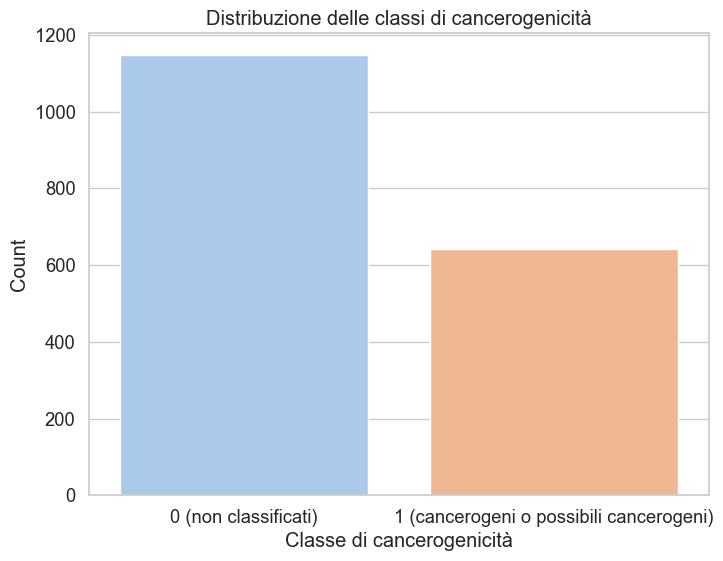

Numero di non classificati: 1147
Numero di cancerogeni / possibili cancerogeni: 643


In [65]:
# Plot della distribuzione usando seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='carcinogenicity_score', data=df_clean, palette='pastel')
plt.xticks([0, 1], ['0 (non classificati)', '1 (cancerogeni o possibili cancerogeni)'])
plt.xlabel('Classe di cancerogenicità')
plt.ylabel('Count')
plt.title('Distribuzione delle classi di cancerogenicità')
plt.show()

non_classificato = df_clean[df_clean["carcinogenicity_score"] == 0]
cancerogeno = df_clean[df_clean["carcinogenicity_score"] == 1]
print(f"Numero di non classificati: {len(non_classificato)}")
print(f"Numero di cancerogeni / possibili cancerogeni: {len(cancerogeno)}")

In [66]:
df_numeriche = df_clean.select_dtypes(include=['number'])
print(df_numeriche.columns)

Index(['moldb_average_mass', 'JCHEM_ACCEPTOR_COUNT',
       'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY',
       'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER',
       'JCHEM_LOGP', 'JCHEM_MDDR_LIKE_RULE', 'JCHEM_NUMBER_OF_RINGS',
       'JCHEM_PHYSIOLOGICAL_CHARGE', 'JCHEM_POLAR_SURFACE_AREA',
       'JCHEM_REFRACTIVITY', 'JCHEM_ROTATABLE_BOND_COUNT',
       'JCHEM_RULE_OF_FIVE', 'JCHEM_VEBER_RULE', 'carcinogenicity_score'],
      dtype='object')


**Correlazione tra ogni variabile numerica e la variabile target**

<Figure size 2000x2000 with 0 Axes>

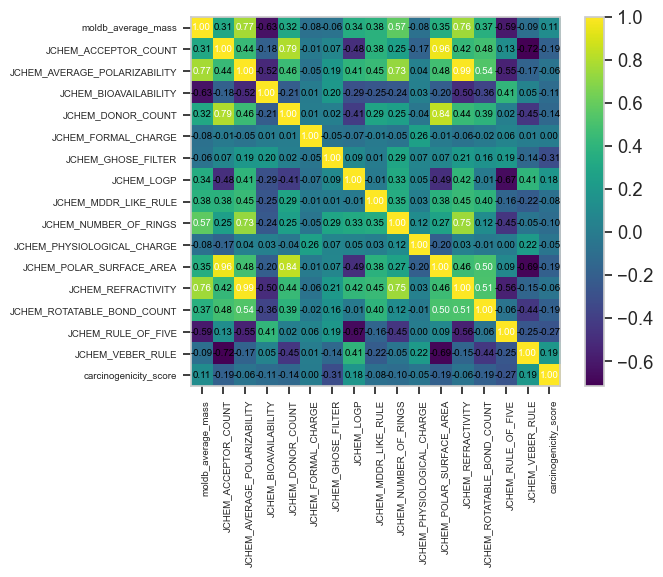

In [67]:
from mlxtend.plotting import scatterplotmatrix
colss = ['moldb_average_mass', 'JCHEM_ACCEPTOR_COUNT',
       'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY',
       'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER',
       'JCHEM_LOGP', 'JCHEM_MDDR_LIKE_RULE', 'JCHEM_NUMBER_OF_RINGS',
       'JCHEM_PHYSIOLOGICAL_CHARGE', 'JCHEM_POLAR_SURFACE_AREA',
       'JCHEM_REFRACTIVITY', 'JCHEM_ROTATABLE_BOND_COUNT',
       'JCHEM_RULE_OF_FIVE', 'JCHEM_VEBER_RULE', 'carcinogenicity_score']

from mlxtend.plotting import heatmap    
cm = np.corrcoef(df_clean[colss].values.T)   # Calcolo coefficiente di correlazione tra colonne  # Converto Dataframe in array Numpy   # Traspongo array
plt.figure(figsize=(20, 20))
hm = heatmap(cm,                          # Matrice di correlazione come input
             row_names=colss,              # Imposto le etichette per le righe
             column_names=colss,
            cell_font_size=7)           # Imposto le etichette per le colonne

plt.xticks(fontsize=7, rotation=90)
plt.yticks(fontsize=7, rotation=0)
plt.show()

In [68]:
# Seleziono le colonne numeriche, escludendo target
df_numeriche = df_clean.select_dtypes(include=[np.number]).drop(columns='carcinogenicity_score')

# Calcolo la correlazione con il target
corr = df_clean[df_numeriche.columns].corrwith(df_clean['carcinogenicity_score'])

print(corr)

# Variabili con correlazione significativa (es. > 0.1)
selezionate = corr[abs(corr) > 0.1].index.tolist()
print("Variabili utili:", selezionate)

moldb_average_mass              0.114990
JCHEM_ACCEPTOR_COUNT           -0.185265
JCHEM_AVERAGE_POLARIZABILITY   -0.058625
JCHEM_BIOAVAILABILITY          -0.107389
JCHEM_DONOR_COUNT              -0.136881
JCHEM_FORMAL_CHARGE             0.001381
JCHEM_GHOSE_FILTER             -0.308332
JCHEM_LOGP                      0.180770
JCHEM_MDDR_LIKE_RULE           -0.083735
JCHEM_NUMBER_OF_RINGS          -0.103406
JCHEM_PHYSIOLOGICAL_CHARGE     -0.048374
JCHEM_POLAR_SURFACE_AREA       -0.189558
JCHEM_REFRACTIVITY             -0.058404
JCHEM_ROTATABLE_BOND_COUNT     -0.189539
JCHEM_RULE_OF_FIVE             -0.273308
JCHEM_VEBER_RULE                0.191967
dtype: float64
Variabili utili: ['moldb_average_mass', 'JCHEM_ACCEPTOR_COUNT', 'JCHEM_BIOAVAILABILITY', 'JCHEM_DONOR_COUNT', 'JCHEM_GHOSE_FILTER', 'JCHEM_LOGP', 'JCHEM_NUMBER_OF_RINGS', 'JCHEM_POLAR_SURFACE_AREA', 'JCHEM_ROTATABLE_BOND_COUNT', 'JCHEM_RULE_OF_FIVE', 'JCHEM_VEBER_RULE']


In [69]:
fig = px.scatter(df_clean, x='moldb_average_mass', y='carcinogenicity_score',
                 color='origin',  # oppure altra categorica
                 size='JCHEM_ACCEPTOR_COUNT',  # opzionale
                 hover_data=['JCHEM_LOGP', 'JCHEM_DONOR_COUNT'],
                 title='Relazione tra peso molecolare e carcinogenicità')
fig.show()


top_corr = corr[abs(corr) > 0.1]

# Converto in DataFrame
df_top_corr = top_corr.reset_index()

# Rinomino le due colonne
df_top_corr = df_top_corr.iloc[:, :2]
df_top_corr.columns = ['Variabile', 'Correlazione']

# Barplot con Plotly
fig = px.bar(df_top_corr, x='Variabile', y='Correlazione',
             title='Correlazione con carcinogenicity_score',
             labels={'Variabile': 'Variabile', 'Correlazione': 'Correlazione'})
fig.update_layout(xaxis_tickangle=45)
fig.show()


fig = px.scatter(df_clean, x='moldb_average_mass', y='carcinogenicity_score',
                 color='state',  # oppure altra categorica
                 size='JCHEM_POLAR_SURFACE_AREA',  # opzionale
                 hover_data=['JCHEM_LOGP', 'JCHEM_POLAR_SURFACE_AREA'],
                 title='Relazione tra peso molecolare e carcinogenicità')
fig.show()



In [70]:
# Impostazioni grafiche
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Variabili molecolari da analizzare
vars_molecolari = ['moldb_average_mass', 'JCHEM_LOGP', 'state', 'origin']



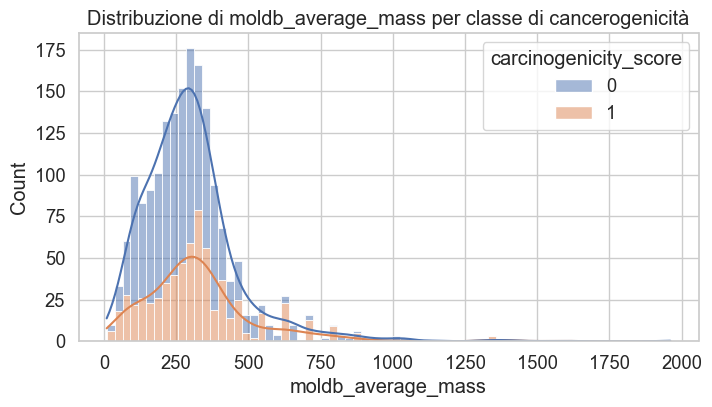

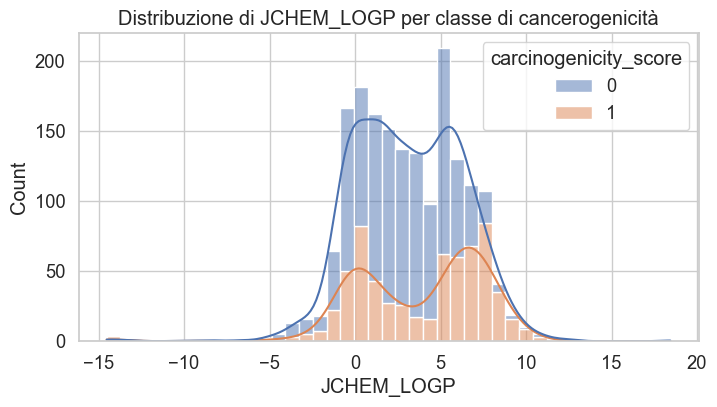

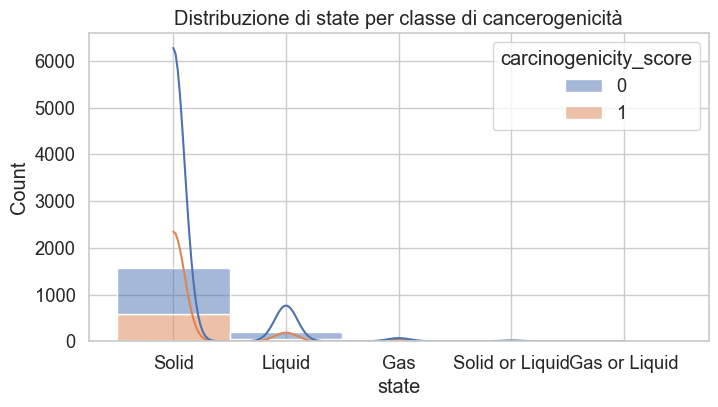

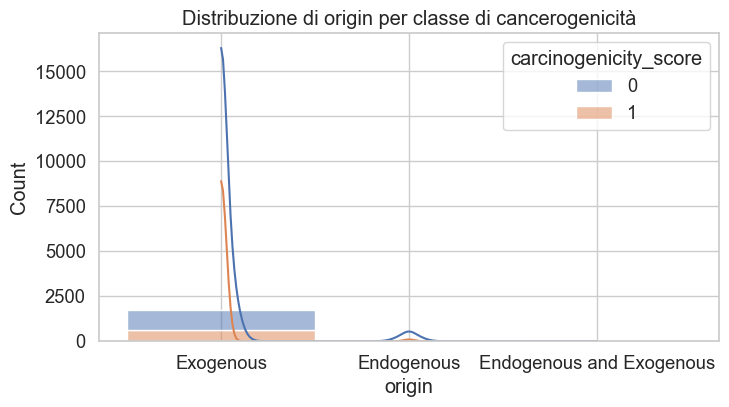

C:\Users\Maura\AppData\Local\Temp\ipykernel_9816\458371011.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




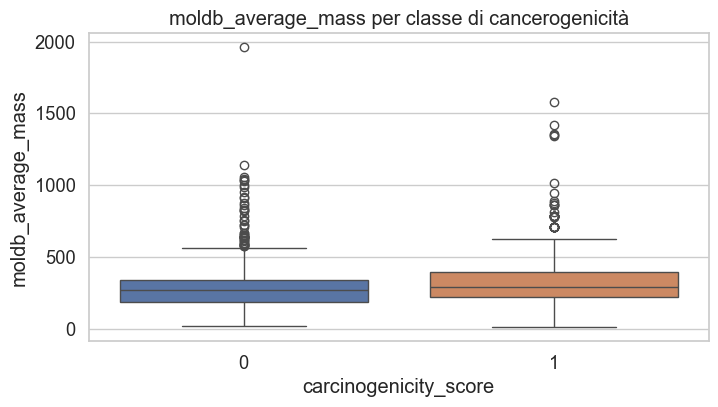

C:\Users\Maura\AppData\Local\Temp\ipykernel_9816\458371011.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




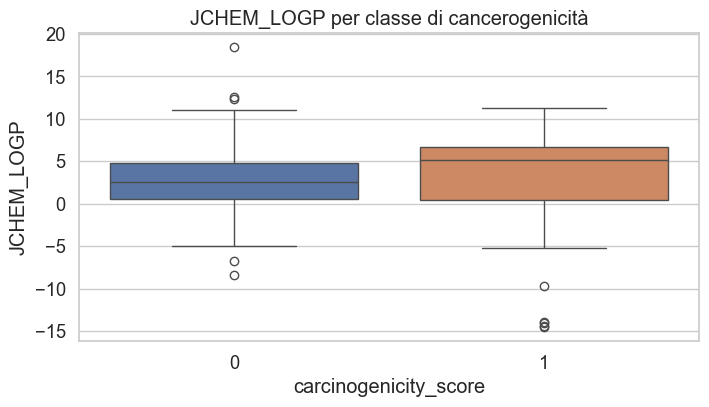

C:\Users\Maura\AppData\Local\Temp\ipykernel_9816\458371011.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




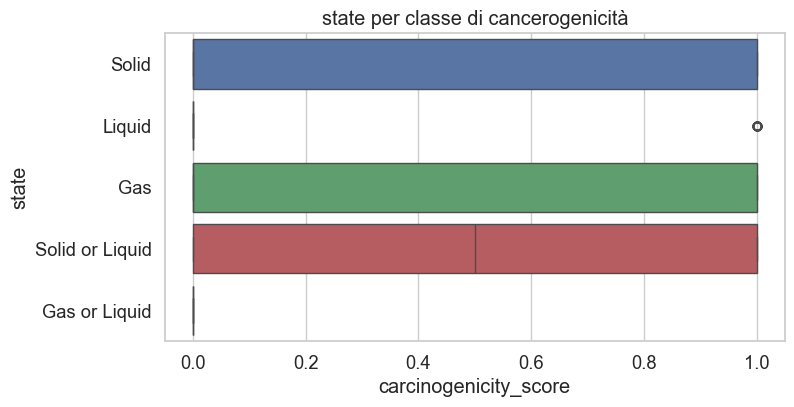

C:\Users\Maura\AppData\Local\Temp\ipykernel_9816\458371011.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




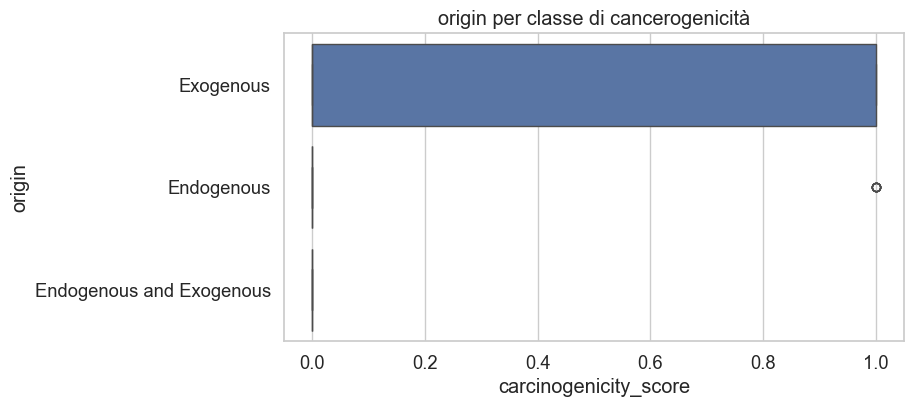

In [71]:
# 1️⃣ Istogrammi / Density plot per ogni variabile molecolare
for col in vars_molecolari:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_clean, x=col, kde=True, hue='carcinogenicity_score', multiple="stack", palette='deep')
    plt.title(f'Distribuzione di {col} per classe di cancerogenicità')
    plt.show()

# ----------------------------------------------
# 2️⃣ Boxplot
for col in vars_molecolari:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df_clean, x='carcinogenicity_score', y=col, palette='deep')
    plt.title(f'{col} per classe di cancerogenicità')
    plt.show()



In [72]:
fig_box = px.scatter(df_clean, x='moldb_average_mass', y='JCHEM_REFRACTIVITY',
                 color='carcinogenicity_score',
                 hover_name='common_name',
                 hover_data=['state', 'origin', 'JCHEM_LOGP'])
plt.show()

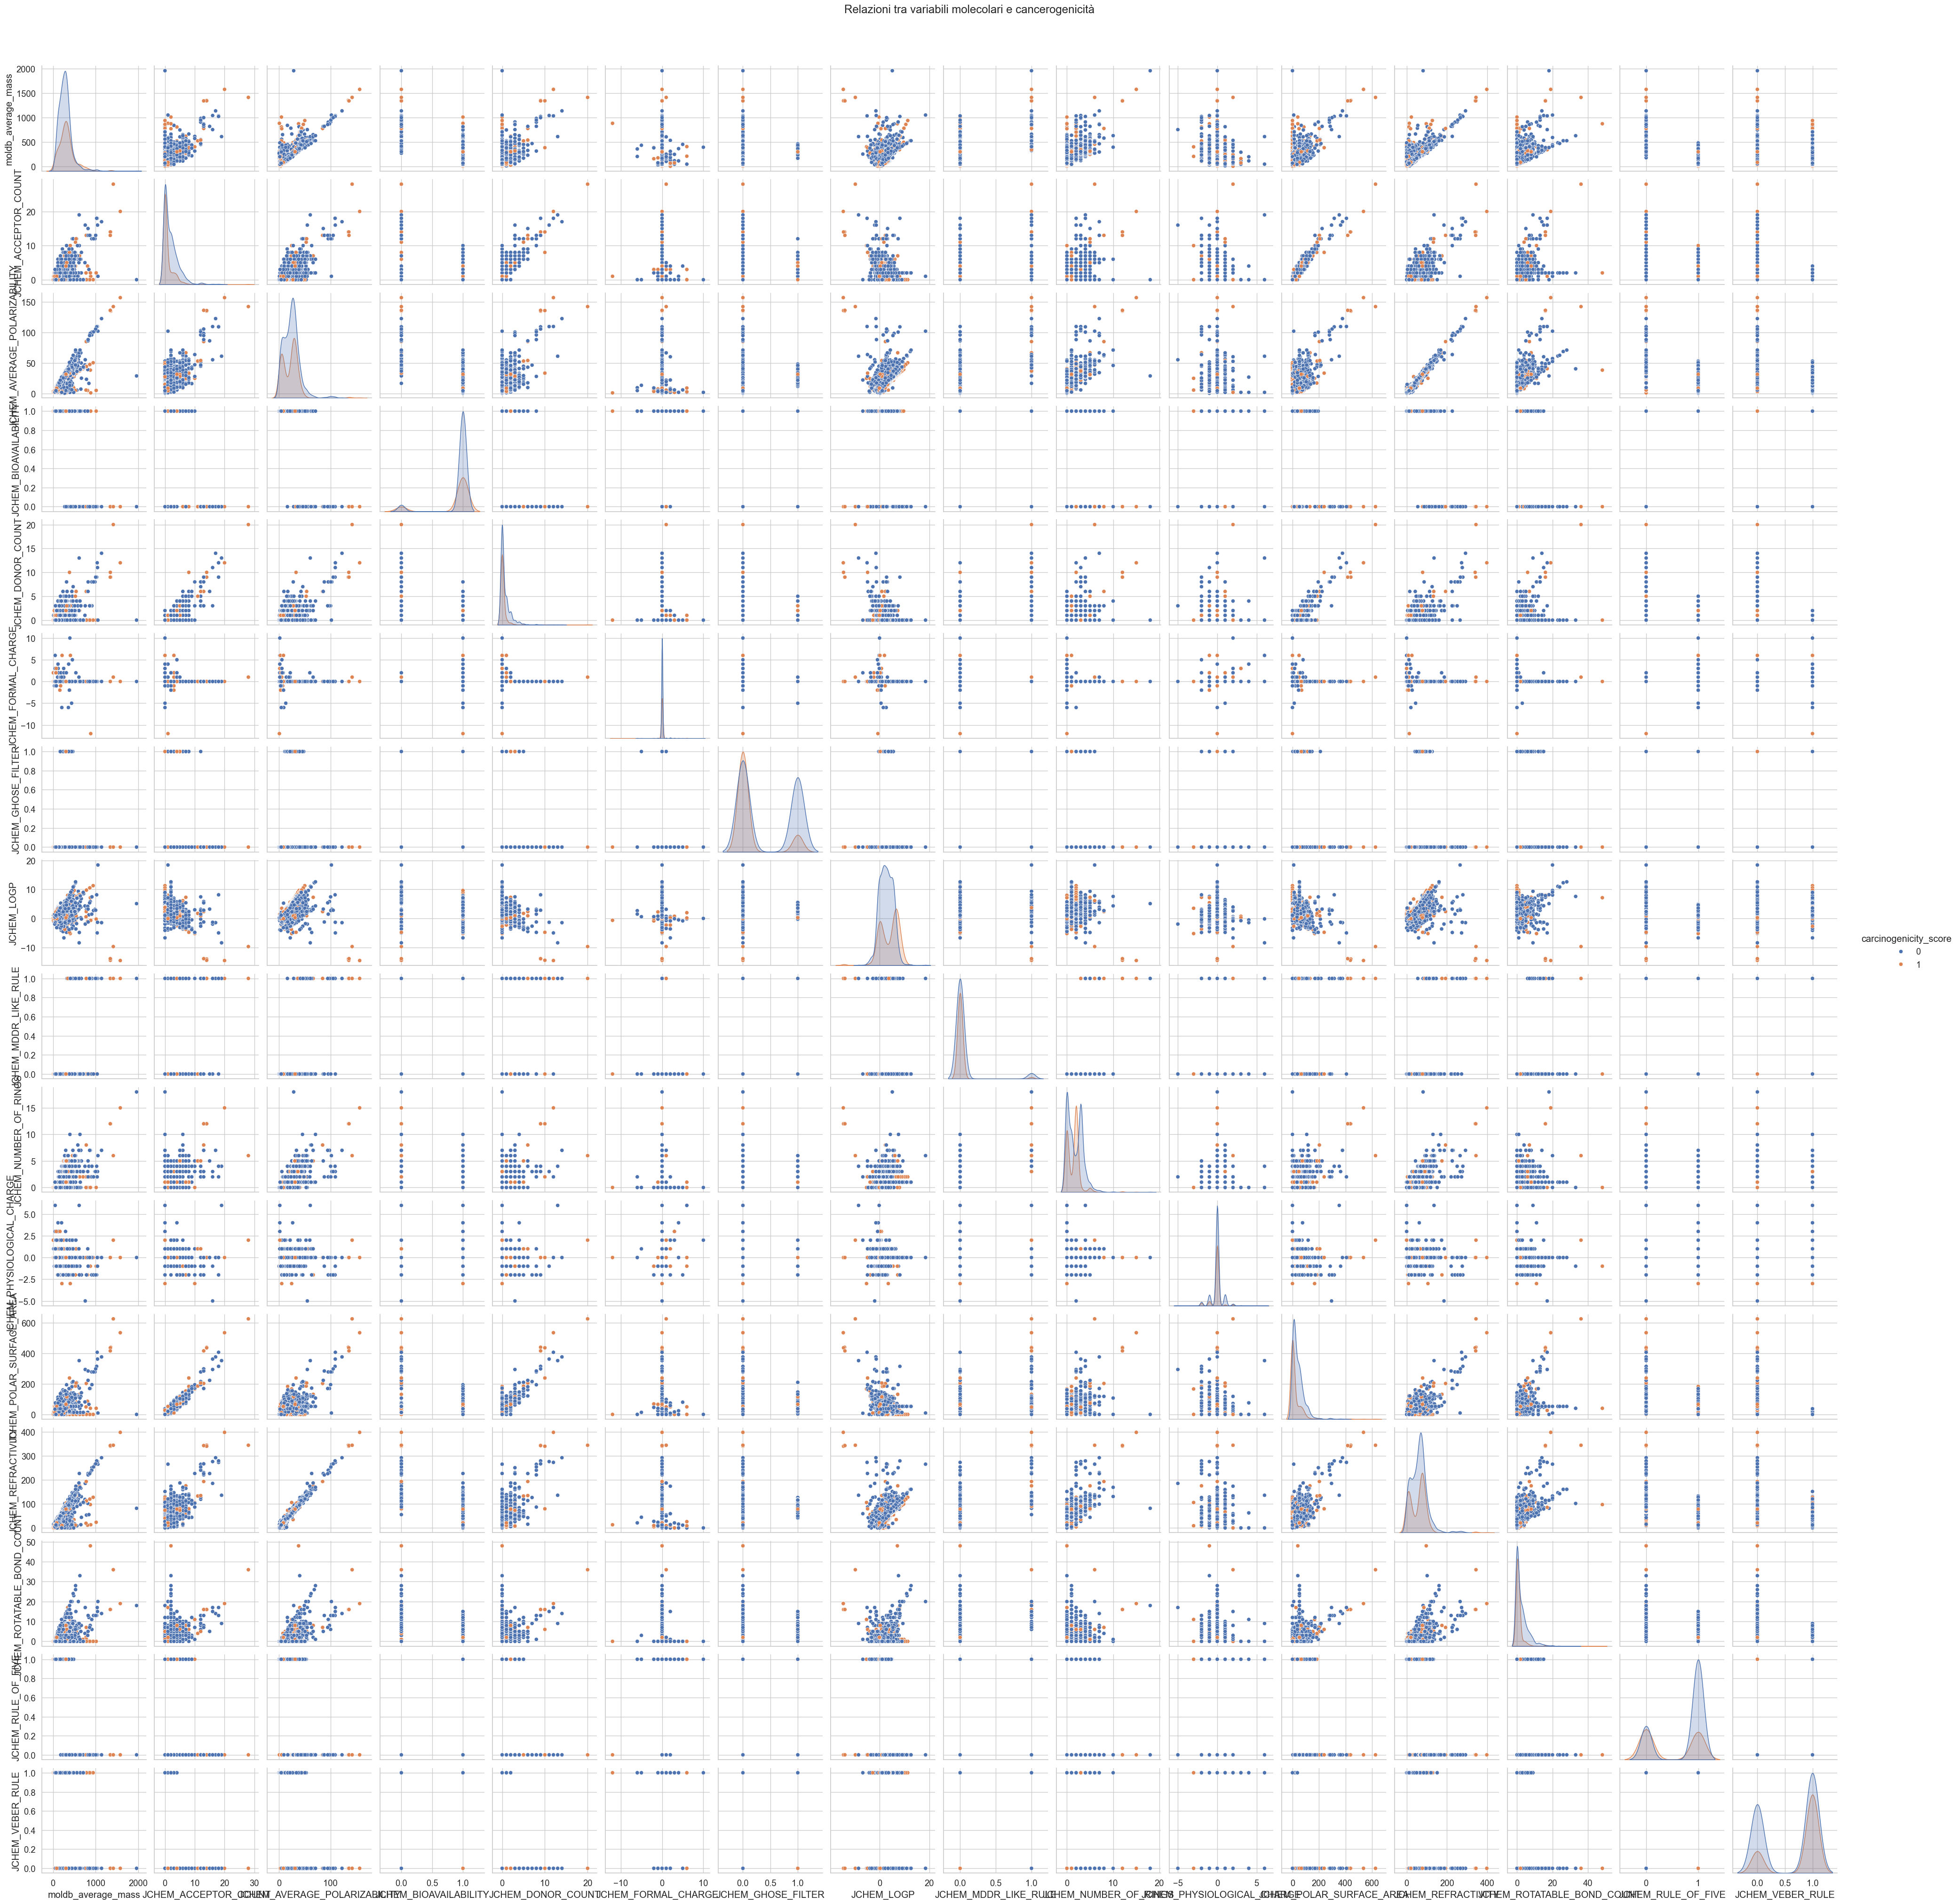

In [73]:
# Pairplot per esplorare relazioni tra tutte le variabili molecolari
sns.pairplot(df_clean, vars=df_numeriche, hue='carcinogenicity_score', palette='deep')
plt.suptitle('Relazioni tra variabili molecolari e cancerogenicità', y=1.02)
plt.show()